<center><h1>Customer Lifetime Value With Probabilistic Model</h1></center>

<center><img src="https://content.webengage.com/wp-content/uploads/sites/4/2016/05/How-to-Calculate-Increase-Customer-.png" alt="Customer Lifetime Value" width="1000" height="600"></center>

### Business Problem

- An online company would like to know each customer lifetime value for 6 months and 12 months periods.
- We will utilize BG/NBD for predicting purchase amounts and then used Gamma-Gamma model to predict Customer Lifetime Value for desired periods. 

### Importing Libraries

In [105]:
import lifetimes

import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
import eda  # my module 

from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from sklearn.preprocessing import MinMaxScaler

from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Reading Data

In [106]:
df_ = pd.read_excel("online_retail_II.xlsx", sheet_name="Year 2010-2011")

In [171]:
df = df_.copy()

#### Data Understanding

In [172]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [173]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      541910 non-null  object        
 1   StockCode    541910 non-null  object        
 2   Description  540456 non-null  object        
 3   Quantity     541910 non-null  int64         
 4   InvoiceDate  541910 non-null  datetime64[ns]
 5   Price        541910 non-null  float64       
 6   Customer ID  406830 non-null  float64       
 7   Country      541910 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [174]:
df.describe()

,Quantity,Price,Customer ID
count,541910.000000,541910.000000,406830.000000
mean,9.552234,4.611138,15287.684160
std,218.080957,96.759765,1713.603074
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


### Data Preparation

In [175]:
df = df[df['Quantity'] > 0 ]
df = df[df['Price'] > 0]
df = df[~df['Invoice'].str.contains("C",na=False)]

### Data Preprocessing

#### Missing Values


In [176]:
df.dropna(inplace=True)

#### Outliers

In [177]:
def capping_outlier(df, variable, upper_limit=0.99, lower_limit=0.01): 
    q1 = df[variable].quantile(lower_limit)
    q3 = df[variable].quantile(upper_limit)

    IQR = q3 - q1

    upper_limit = q3 + 1.5 * IQR
    lower_limit = q1 - 1.5 * IQR

    df.loc[df[variable] > upper_limit, variable] = upper_limit
    df.loc[df[variable] < lower_limit, variable] = lower_limit

In [178]:
capping_outlier(df,'Price')

In [179]:
capping_outlier(df,'Quantity')

#### Filtering only United Kingdom for Country

In [180]:
df = df[df.Country == 'United Kingdom']

In [181]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


#### Creating Column 'Total Price'

In [182]:
df['Total Price'] = df['Price'] * df['Quantity']

#### Assign a Date for Analysis Column

In [183]:
today_date = pd.datetime(2011,12,11)

In [184]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total Price
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


#### Recency , Frequency , T and Monetary Value

In [185]:
clv = df.groupby('Customer ID').agg({'InvoiceDate': [lambda x : (x.max() - x.min()).days,lambda x : (today_date - x.min()).days],
                               'Invoice' : lambda x : x.nunique(),
                               'Total Price' : lambda x : x.sum()})

In [186]:
clv.columns = clv.columns.droplevel(0)

In [187]:
clv.columns = ['Recency','T','Frequency','Monetary']

#### Filtering Dataset with Customer who purchased more than once


In [188]:
clv = clv[clv['Frequency']>1]

In [189]:
clv.head()

,Recency,T,Frequency,Monetary
Customer ID,,,,
12747.0,366,370,11,4196.01
12748.0,372,374,209,32380.41
12749.0,209,214,5,4077.94
12820.0,323,327,4,942.34
12822.0,16,88,2,948.88


#### Getting Average Monetary

In [190]:
clv = clv[clv['Monetary'] > 0]
clv['Monetary'] = clv['Monetary'] / clv['Frequency']

In [191]:
clv.head()

,Recency,T,Frequency,Monetary
Customer ID,,,,
12747.0,366,370,11,381.455455
12748.0,372,374,209,154.930191
12749.0,209,214,5,815.588000
12820.0,323,327,4,235.585000
12822.0,16,88,2,474.440000


In [192]:
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(clv['Frequency'], clv['Recency'], clv['T'])

<lifetimes.BetaGeoFitter: fitted with 2570 subjects, a: 0.12, alpha: 81.62, b: 2.51, r: 2.21>

#### Summary of BetaGeoFitter

In [193]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,2.213307,0.081434,2.053697,2.372918
alpha,81.623457,3.495006,74.773247,88.473668
a,0.117181,0.013297,0.091118,0.143243
b,2.505639,0.243061,2.029239,2.982039


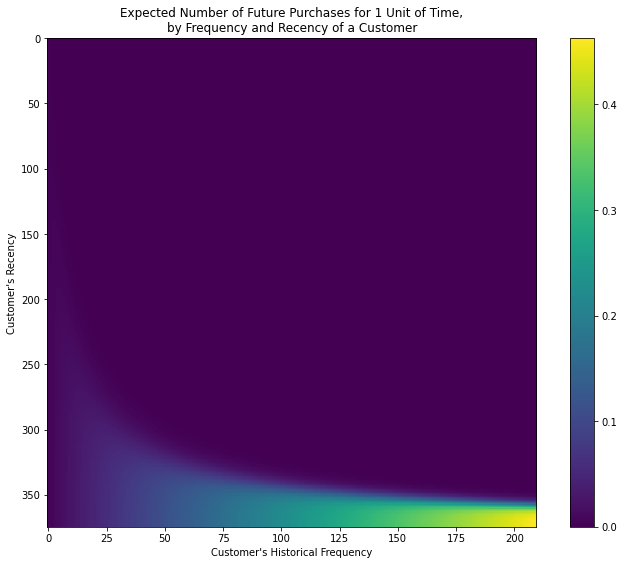

In [194]:
plt.figure(figsize=(12,9))
plot_frequency_recency_matrix(bgf)
plt.show()

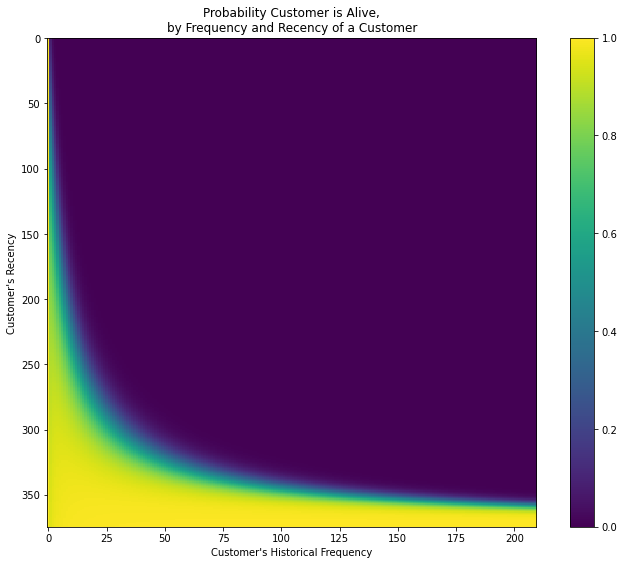

In [195]:
plt.figure(figsize=(12,9))
plot_probability_alive_matrix(bgf)
plt.show()

#### Expected Purchase  in 6 Months

In [196]:
t = 180 # 30 day period
clv['expected_purc_6_months'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, clv['Frequency'], clv['Recency'], clv['T'])
clv.sort_values(by='expected_purc_6_months',ascending=False).head(5)

,Recency,T,Frequency,Monetary,expected_purc_6_months
Customer ID,,,,,
12748.0,372,374,209,154.930191,81.628170
17841.0,371,374,124,330.134355,48.740321
13089.0,366,370,97,606.362474,38.617783
14606.0,372,374,93,130.139032,36.777602
15311.0,373,374,91,667.779121,36.016860


#### Expected Purchase ın 12 Months

In [197]:
t = 360
clv['expected_purc_12_months'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, clv['Frequency'], clv['Recency'], clv['T'])
clv.sort_values(by='expected_purc_12_months',ascending=False).head(5)

,Recency,T,Frequency,Monetary,expected_purc_6_months,expected_purc_12_months
Customer ID,,,,,,
12748.0,372,374,209,154.930191,81.628170,160.548193
17841.0,371,374,124,330.134355,48.740321,95.861404
13089.0,366,370,97,606.362474,38.617783,75.943217
14606.0,372,374,93,130.139032,36.777602,72.332050
15311.0,373,374,91,667.779121,36.016860,70.835751


### Gamma - Gamma Model

The Gamma-Gamma Model can predict the most likely value per transaction in the future

#### Assumption

The model we are going to use to estimate the CLV for our userbase is called the Gamma-Gamma submodel, which relies upon an important assumption. The Gamma-Gamma submodel, in fact, assumes that there is no relationship between the monetary value and the purchase frequency. In practice we need to check whether the Pearson correlation between the two vectors is close to 0 in order to use this model.

In [198]:
clv[['Frequency','Monetary']].corr()

,Frequency,Monetary
Frequency,1.000000,0.157255
Monetary,0.157255,1.000000


At this point we can train our Gamma-Gamma submodel and predict the conditional, expected average lifetime value of our customers.

In [199]:
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(clv["Frequency"],
        clv["Monetary"])

<lifetimes.GammaGammaFitter: fitted with 2570 subjects, p: 3.81, q: 0.35, v: 3.75>

### 6 months Customer Life Time Value

In [200]:
clv['6_monhths_clv']=ggf.customer_lifetime_value(bgf,
                                   clv["Frequency"],
                                   clv["Recency"],
                                   clv["T"],
                                   clv["Monetary"],
                                   time=6,
                                   freq='D',
                                   discount_rate=0.01)

In [201]:
clv.head()

,Recency,T,Frequency,Monetary,expected_purc_6_months,expected_purc_12_months,6_monhths_clv
Customer ID,,,,,,,
12747.0,366,370,11,381.455455,5.100607,10.025868,1911.104735
12748.0,372,374,209,154.930191,81.628170,160.548193,12229.306448
12749.0,209,214,5,815.588000,4.169137,8.143255,3404.849199
12820.0,323,327,4,235.585000,2.611912,5.124343,623.517682
12822.0,16,88,2,474.440000,3.161164,6.114187,1591.132692


###  12 Months Customer Lifetime Value

In [202]:
clv['12_months_clv'] = ggf.customer_lifetime_value(bgf,
                            clv["Frequency"],
                             clv["Recency"],
                             clv["T"],
                             clv["Monetary"],
                             time=12,
                             freq="D",
                             discount_rate=0.01)

#### Segmentation Customers by 6 Months CLV

In [203]:
clv['Segment'] =  pd.qcut(clv['6_monhths_clv'],4,labels = ['Hibernating','Need Attention',
                                                          'Loyal Customers','Champions'])

### Final Dataframe

In [204]:
clv.head()

,Recency,T,Frequency,Monetary,expected_purc_6_months,expected_purc_12_months,6_monhths_clv,12_months_clv,Segment
Customer ID,,,,,,,,,
12747.0,366,370,11,381.455455,5.100607,10.025868,1911.104735,3649.472536,Champions
12748.0,372,374,209,154.930191,81.628170,160.548193,12229.306448,23367.127112,Champions
12749.0,209,214,5,815.588000,4.169137,8.143255,3404.849199,6462.042095,Champions
12820.0,323,327,4,235.585000,2.611912,5.124343,623.517682,1188.492464,Need Attention
12822.0,16,88,2,474.440000,3.161164,6.114187,1591.132692,2991.086802,Loyal Customers


### Group by Segment

In [205]:
clv.groupby('Segment').mean()

,Recency,T,Frequency,Monetary,expected_purc_6_months,expected_purc_12_months,6_monhths_clv,12_months_clv
Segment,,,,,,,,
Hibernating,154.489891,283.891135,3.068429,178.889193,1.769037,3.458122,266.951623,507.500067
Need Attention,215.834891,266.830218,3.989097,260.735481,2.983166,5.829408,703.080850,1336.036318
Loyal Customers,208.978193,245.889408,5.457944,352.807407,4.013086,7.832423,1257.349961,2386.239553
Champions,220.118196,241.564541,11.287714,591.567014,6.788049,13.263364,3802.204156,7220.768378
